In [5]:
import random
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from configobj import ConfigObj
config = ConfigObj('config')

ml_home = config.get(
    'ml_home', '/')
sys.path.append('../../util')
sys.path.append(ml_home)
sys.path.append(ml_home+ '/features')

sys.path.append(ml_home+ '/eda')
import plot_helper
import myutil
import ml_util  
import features


In [6]:
pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (15, 5)
%matplotlib inline

In [7]:
sys.path.append('credit')
from eda_uti import *

In [8]:
fname = 'data/credit-training.csv'
df_orig, xnames, yname = get_data(fname, flag_test=0)

original column names:
Index([u'unnamed: 0', u'serious_dlqin2yrs',
       u'revolving_utilization_of_unsecured_lines', u'age',
       u'number_of_time30-59_days_past_due_not_worse', u'debt_ratio',
       u'monthly_income', u'number_of_open_credit_lines_and_loans',
       u'number_of_times90_days_late', u'number_real_estate_loans_or_lines',
       u'number_of_time60-89_days_past_due_not_worse',
       u'number_of_dependents'],
      dtype='object')


### random sample 5k for testing code

In [9]:
df = df_orig
'''
k = 10000
lst_i = random.sample(xrange(df_orig.shape[0]), k)
df = df_orig.iloc[lst_i,:]
'''

'\nk = 10000\nlst_i = random.sample(xrange(df_orig.shape[0]), k)\ndf = df_orig.iloc[lst_i,:]\n'

### get summary stats

In [10]:
print "shape: ", df_orig.shape

shape:  (150000, 12)


In [11]:
print ml_util.count_null(df_orig)

                     not_null   null  pct_null
variable                                      
age                    150000      0         0
dlqin2yrs              150000      0         0
dti                    150000      0         0
id                     150000      0         0
monthly_income         120269  29731        19
n_30-59d_late          150000      0         0
n_60-89d_late          150000      0         0
n_90d_late             150000      0         0
n_dependents           146076   3924         2
n_house_loans          150000      0         0
n_loans_creditlines    150000      0         0
revolv_util_clines     150000      0         0


In [12]:
#df.apply(pd.Series.value_counts, axis=1).fillna(0)
print df.dlqin2yrs.value_counts()
#print df.nunique()
print df.mode()
print df.count()
#print df.nuni

0    139974
1     10026
dtype: int64
   id  dlqin2yrs  age  revolv_util_clines  dti  monthly_income  \
0 NaN          0   49                   0    0            5000   

   n_loans_creditlines  n_house_loans  n_dependents  n_30-59d_late  \
0                    6              0             0              0   

   n_60-89d_late  n_90d_late  
0              0           0  
id                     150000
dlqin2yrs              150000
age                    150000
revolv_util_clines     150000
dti                    150000
monthly_income         120269
n_loans_creditlines    150000
n_house_loans          150000
n_dependents           146076
n_30-59d_late          150000
n_60-89d_late          150000
n_90d_late             150000
dtype: int64


## summary stats y

In [13]:
icol_y = 1
print '%i total samples, %i positives %.2f%%' % \
(df.shape[0], df.iloc[:,icol_y].sum(),100.0* df.iloc[:,icol_y].sum()/df.shape[0])
unique, counts = np.unique(df.iloc[:,icol_y], return_counts=True)
print 'counts by y'
print np.asarray((unique, counts)).T

150000 total samples, 10026 positives 6.68%
counts by y
[[     0 139974]
 [     1  10026]]


- im-balanced class, 6.7% positive. need adjust models accordinly.

## summary stats X - Univariate

In [14]:
ml_util.describe_df(df).T

,count,unique_counts,min,max,mean,50%,std,25%,75%
id,150000,150000,1,150000,75000.500000,75000.500000,43301.414527,37500.750000,112500.250000
dlqin2yrs,150000,2,0,1,0.066840,0.000000,0.249746,0.000000,0.000000
age,150000,86,0,109,52.295207,52.000000,14.771866,41.000000,63.000000
revolv_util_clines,150000,125728,0,50708,6.048438,0.154181,249.755371,0.029867,0.559046
dti,150000,114194,0,329664,353.005076,0.366508,2037.818523,0.175074,0.868254
monthly_income,120269,13594,0,3008750,6670.221237,5400.000000,14384.674215,3400.000000,8249.000000
n_loans_creditlines,150000,58,0,58,8.452760,8.000000,5.145951,5.000000,11.000000
n_house_loans,150000,28,0,54,1.018240,1.000000,1.129771,0.000000,2.000000
n_dependents,146076,13,0,20,0.757222,0.000000,1.115086,0.000000,1.000000
n_30-59d_late,150000,16,0,98,0.421033,0.000000,4.192781,0.000000,0.000000


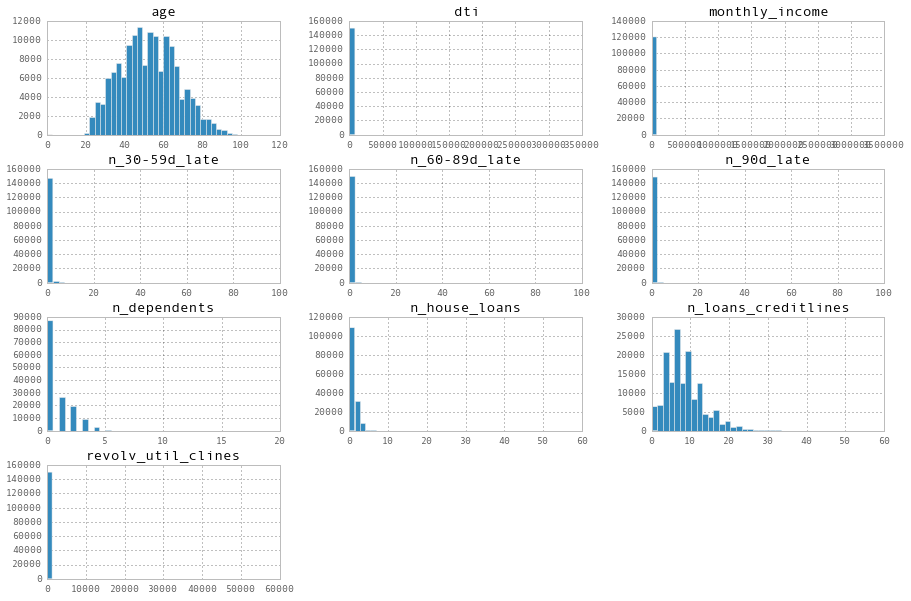

In [15]:
colname_id = 'id'
colname_y = 'dlqin2yrs'
colnames_X = df.columns.difference([colname_id, colname_y])
df[colnames_X].hist( bins= 40, figsize=(15, 10))
plt.show()

## feature engineering

df_orig  
df: sampling  
df2: with capped features

### data cleaning & adding new features

In [16]:
df_orig['age'] = df_orig['age'].apply(lambda x: x if x > 16 else df_orig.age.median())
df_orig['n_dependents'].fillna(0)

df_orig['debt'] = df_orig['monthly_income'] * df_orig['dti']
cond_dti_is_debt = np.all([df_orig['dti'] > 0\
                             ,df_orig['monthly_income'] == 0], axis=0 )
df_orig['debt'] = np.where(cond_dti_is_debt, df_orig['dti'], df_orig['debt'])

cond_dti_is_debt = np.all([df_orig['dti'] > 0\
                             ,df_orig['monthly_income'].isnull()], axis=0 )
df_orig['debt'] = np.where(cond_dti_is_debt, df_orig['dti'], df_orig['debt'])
df_orig['debt'] = df_orig['debt'].fillna(-1)

df_orig['debt_is_0'] = df_orig['debt'].apply(lambda x: 1 if x == 0 else 0)

monthly_income_min_val = 99
dt_max_val = 30

# monthly income 0 or 1: 2239 rows 2-99: 40
df_orig['mon_income_valid'] = df_orig['monthly_income'].apply(lambda x: 1 if x > monthly_income_min_val else 0)
df_orig['mon_income_valid'].fillna(0)
df_orig['mon_income_is_1'] = df_orig['monthly_income'].apply(lambda x: 1 if  x == 1 else 0)
df_orig['mon_income_is_0'] = df_orig['monthly_income'].apply(lambda x: 1 if  x == 0 else 0)

# monthly_income_fixed: -1 code for invalid
df_orig['monthly_income_fixed'] = df_orig['monthly_income'].apply(lambda x: x if x > monthly_income_min_val else -1)
df_orig['monthly_income_fixed'] = df_orig['monthly_income_fixed'].fillna(-1)
df_orig['mon_income_is_k'] = df_orig['monthly_income_fixed'].apply(lambda x: 'end_in_k' if x % 1000 ==0 else 'not_in_k')

df_orig['n_creditline'] = df_orig.n_loans_creditlines - df_orig.n_house_loans

df_orig['dti_is_int'] = df_orig['dti'].apply(lambda x: 1 if (x > 0) & (int(x) - x == 0)  else 0)
# dti_fixed: -1 invalid
df_orig['dti_fixed'] = np.where(df_orig['dti_is_int'], -1, df_orig['dti'])

df_orig['dti_is_0'] = df_orig['dti'].apply(lambda x: 1 if x == 0 else 0)
df_orig['dti_gt_33'] = df_orig['dti_fixed'].apply(lambda x: 1 if x > 0.33 else 0)
df_orig['dti_gt_40'] = df_orig['dti_fixed'].apply(lambda x: 1 if x > 0.40 else 0)


In [17]:
cond_dti_is_debt = np.all([df_orig['dti'] > 0\
                             ,df_orig['monthly_income'].isnull()], axis=0 )
df_orig[cond_dti_is_debt].head(10).T

,6,8,16,32,41,58,62,71,86,92
id,7,9,17,33,42,59,63,72,87,93
dlqin2yrs,0,0,0,0,0,0,0,0,0,0
age,57,27,78,62,81,43,72,67,58,52
revolv_util_clines,0.3056825,0.1169506,0.06108612,0.08341801,0.07289757,0.5411088,0.1011558,0.142013,0.3605096,0.7848357
dti,5710,46,2058,977,75,2477,1720,1824,3282,2662
monthly_income,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n_loans_creditlines,8,2,10,6,7,3,12,7,8,10
n_house_loans,3,0,2,1,0,1,2,2,2,2
n_dependents,0,NaN,0,0,0,2,0,0,0,0
n_30-59d_late,0,0,0,0,0,0,0,0,1,0


### capping

In [18]:
age_max = 75
cols_tocap = ['age'
,'revolv_util_clines'
,'dti_fixed'
,'monthly_income_fixed' 
,'n_loans_creditlines'
,'n_house_loans'
,'n_dependents'
]
df_x_capped = features.cap_df(df, cols_tocap, pct = 0.99)
print "\n", "historgram after capping"
#hists(df_x_capped, df_x_capped.columns)
print df.columns

df2 = pd.concat([df, df_x_capped], axis = 1)

df2['age_cap_manual'] = df2['age'].apply(lambda x: x if x <=age_max else age_max)
df2.n_creditline.describe()


historgram after capping
Index([                  u'id',            u'dlqin2yrs',
                        u'age',   u'revolv_util_clines',
                        u'dti',       u'monthly_income',
        u'n_loans_creditlines',        u'n_house_loans',
               u'n_dependents',        u'n_30-59d_late',
              u'n_60-89d_late',           u'n_90d_late',
                       u'debt',            u'debt_is_0',
           u'mon_income_valid',      u'mon_income_is_1',
            u'mon_income_is_0', u'monthly_income_fixed',
            u'mon_income_is_k',         u'n_creditline',
                 u'dti_is_int',            u'dti_fixed',
                   u'dti_is_0',            u'dti_gt_33',
                  u'dti_gt_40'],
      dtype='object')


count    150000.000000
mean          7.434520
std           4.765642
min           0.000000
25%           4.000000
50%           7.000000
75%          10.000000
max          57.000000
Name: n_creditline, dtype: float64

In [19]:
def func_n_days_late_binning(x):
    if x == 0:
        return 0
    if x > 90:
        return -1
    else:
        return x

colsnames = ['n_90d_late','n_30-59d_late','n_60-89d_late']
cols_mod_names = [x + '_mod' for x in colsnames]
for col in colsnames:
    col_mod = col + '_mod'
    col_missing = col + '_missing'
    df2[col_mod] = df[col].apply(func_n_days_late_binning) # missing value coded as -1; won't work for linear model
    df2[col_missing] = df[col].apply(lambda x: 1 if x > 90 else 0)
df2['total_late_days'] = df2[cols_mod_names].apply(lambda x: np.sum(x), axis = 1)
df2['total_late_days'] = df2['total_late_days'].apply(lambda x: -1 if x < 0 else x)
print df2.head(5)

   id  dlqin2yrs  age  revolv_util_clines       dti  monthly_income  \
0   1          1   45            0.766127  0.802982            9120   
1   2          0   40            0.957151  0.121876            2600   
2   3          0   38            0.658180  0.085113            3042   
3   4          0   30            0.233810  0.036050            3300   
4   5          0   49            0.907239  0.024926           63588   

   n_loans_creditlines  n_house_loans  n_dependents  n_30-59d_late  \
0                   13              6             2              2   
1                    4              0             1              0   
2                    2              0             0              1   
3                    5              0             0              0   
4                    7              1             0              1   

        ...         n_house_loans_capped  n_dependents_capped  age_cap_manual  \
0       ...                            4                    2          

### log transformation

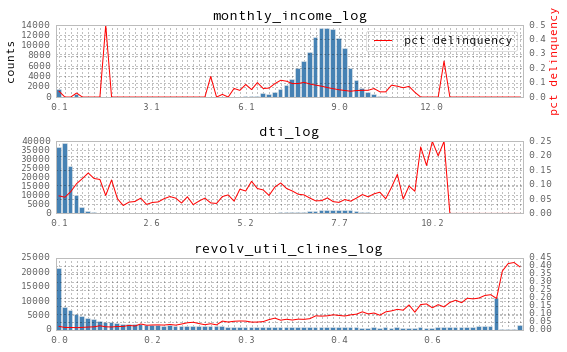

In [83]:
import math
df2['monthly_income_log'] = df2['monthly_income'].apply(lambda x: np.log(x+1))
df2['dti_log'] = df2['dti'].apply(lambda x: np.log(x+1))
df2['revolv_util_clines_log'] = df2['revolv_util_clines_capped'].apply(lambda x: np.log(x+1))
conti_col_names = ['monthly_income_log','dti_log','revolv_util_clines_log' ]
fig = plot_helper.plot_ybinary_xnumerical(df2[conti_col_names], df2[yname], n_per_row=1, nbins = 80, figsize=(8,5))
fig.show()

In [119]:
df2['income_per_person'] =  df2[['monthly_income_fixed','n_dependents_capped']].apply(lambda x:\
                            x[0]/(1.0+x[1]), axis = 1)
df2['income_per_person'] = df2['income_per_person'].apply(lambda x: -1 if x < 0 else x)
df2['monthly_disposable'] = df2[['monthly_income_fixed','debt']].apply(lambda x:\
                        x[0] - x[1], axis = 1)
df2['monthly_disposable'] = np.where(np.any([df2['monthly_income_fixed']==-1, df2['debt']==-1],axis=0), -1,df2['monthly_disposable'] )


In [123]:
df2['debt_log'] = df2['debt'].apply(lambda x: np.log(x+2))
df2['monthly_disposable_log'] = df2['monthly_disposable'].apply(lambda x: np.log(x+2))

In [85]:
print df2.columns

Index([                         u'id',                   u'dlqin2yrs',
                               u'age',          u'revolv_util_clines',
                               u'dti',              u'monthly_income',
               u'n_loans_creditlines',               u'n_house_loans',
                      u'n_dependents',               u'n_30-59d_late',
                     u'n_60-89d_late',                  u'n_90d_late',
                              u'debt',                   u'debt_is_0',
                  u'mon_income_valid',             u'mon_income_is_1',
                   u'mon_income_is_0',        u'monthly_income_fixed',
                   u'mon_income_is_k',                u'n_creditline',
                        u'dti_is_int',                   u'dti_fixed',
                          u'dti_is_0',                   u'dti_gt_33',
                         u'dti_gt_40',                  u'age_capped',
         u'revolv_util_clines_capped',            u'dti_fixed_capped',
      

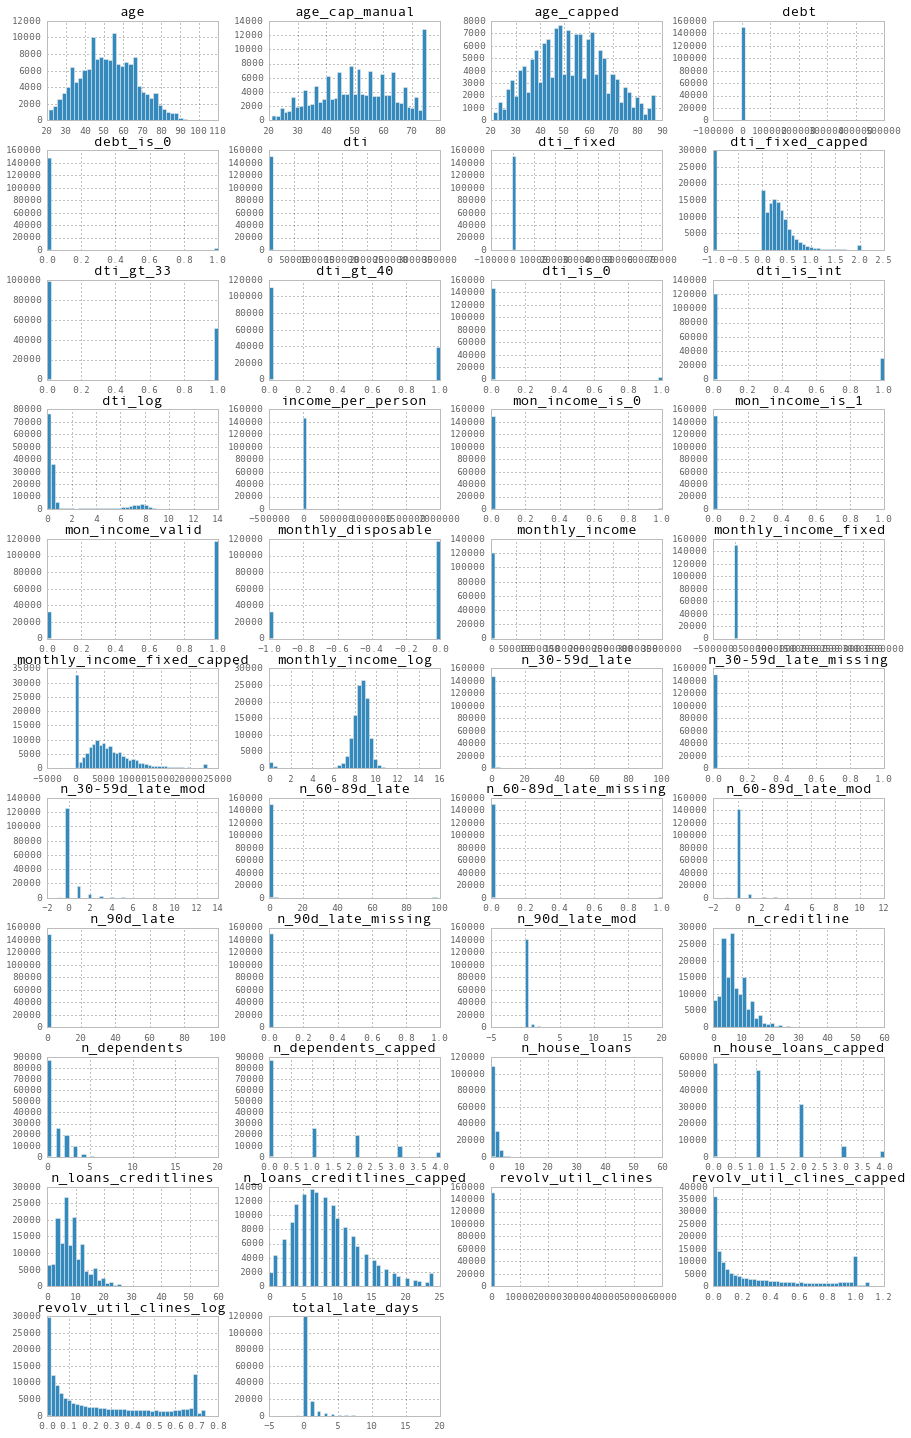

In [86]:
colname_id = 'id'
colname_y = 'dlqin2yrs'
colnames_X = df2.columns.difference([colname_id, colname_y])
n_figs = len(colnames_X)
n_col_fig = 4
n_row_fig =  n_figs // n_col_fig + ( (n_figs % n_col_fig)>0 )
df2[colnames_X].hist( bins= 40, figsize=(15, 25),layout=(n_row_fig, n_col_fig))
plt.show()


In [87]:
ml_util.describe_df(df_orig).T

,count,unique_counts,min,max,mean,50%,std,25%,75%
id,150000,150000,1,150000,75000.5,75000.5,43301.41,37500.75,112500.2
dlqin2yrs,150000,2,0,1,0.06684,0,0.2497455,0,0
age,150000,85,21,109,52.29555,52,14.77125,41,63
revolv_util_clines,150000,125728,0,50708,6.048438,0.1541807,249.7554,0.02986744,0.5590462
dti,150000,114194,0,329664,353.0051,0.3665078,2037.819,0.1750738,0.8682538
monthly_income,120269,13594,0,3008750,6670.221,5400,14384.67,3400,8249
n_loans_creditlines,150000,58,0,58,8.45276,8,5.145951,5,11
n_house_loans,150000,28,0,54,1.01824,1,1.129771,0,2
n_dependents,146076,13,0,20,0.7572223,0,1.115086,0,1
n_30-59d_late,150000,16,0,98,0.4210333,0,4.192781,0,0


### explor missing values, outliers, data codings 

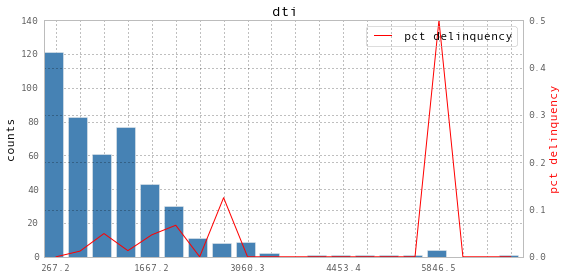

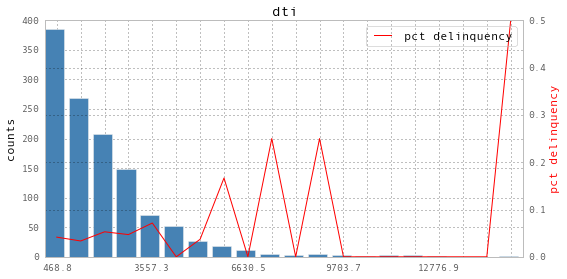

In [88]:
# explore dti

feature_name = 'dti'
df_this = df_orig

cond_dit_income_mixedup = (df_this['mon_income_valid'] == 0) & (df_this['dti'] > 99)\
    & (df_this['dti'] < 20000) \
    & (df_this['monthly_income'] == 1)       
df_subset = df_this[cond_dit_income_mixedup]
fig = plot_helper.plot_ybinary_xnumerical(df_subset[[feature_name]], df_subset[yname], n_per_row=1, nbins = 20, figsize=(8,4))
fig.show()

cond_dit_income_mixedup = (df_this['mon_income_valid'] == 0) & (df_this['dti'] > 99)\
    & (df_this['dti'] < 20000) \
    & (df_this['monthly_income'] == 0) 
df_subset = df_this[cond_dit_income_mixedup]
fig = plot_helper.plot_ybinary_xnumerical(df_subset[[feature_name]], df_subset[yname], n_per_row=1, nbins = 20, figsize=(8,4))
fig.show()

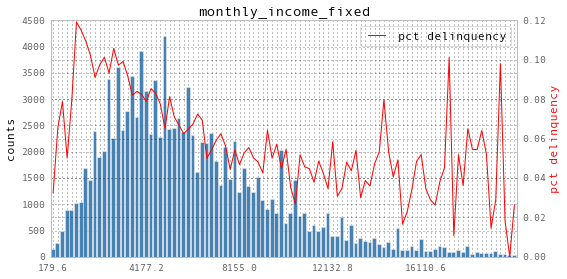

In [89]:
feature = 'monthly_income_fixed'
cond = (df_orig[feature] < 20000) & (df_orig[feature] > 0)
df_subset = df_orig[cond]
fig = plot_helper.plot_ybinary_xnumerical(df_subset[[feature]], df_subset[yname], n_per_row=1, nbins = 100, figsize=(8,4))
fig.show()

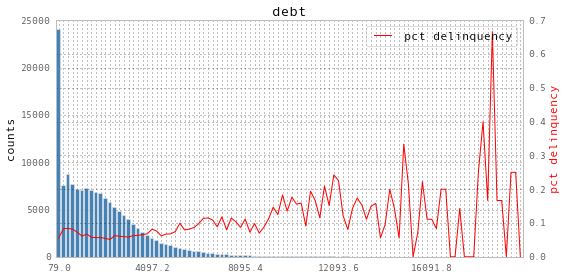

In [90]:
df_subset = df_orig[df_orig['debt'] < 20000]
fig = plot_helper.plot_ybinary_xnumerical(df_subset[['debt']], df_subset[yname], n_per_row=1, nbins = 100, figsize=(8,4))
fig.show()

In [91]:
df_orig[['dti','debt']].count()

dti     150000
debt    150000
dtype: int64

In [92]:
cond = (df_orig['monthly_income'].isnull()) | (df_orig['monthly_income']==0)
cond2 = df_orig['dti'] < 10
print df_orig[cond & cond2].shape, df_orig[cond & cond2].dlqin2yrs.mean()
print df_orig[cond & cond2].head(20)

(3031, 25) 0.0481689211481
        id  dlqin2yrs  age  revolv_util_clines  dti  monthly_income  \
52      53          0   62            1.000000    0             NaN   
115    116          0   74            0.007508    7             NaN   
159    160          0   63            0.000000    2             NaN   
238    239          0   28            1.000000    0             NaN   
331    332          0   29            1.000000    0             NaN   
395    396          0   83            0.000686    0             NaN   
436    437          0   97            0.007000    3             NaN   
509    510          0   91            1.000000    0             NaN   
518    519          0   56            1.000000    7             NaN   
530    531          0   82            0.000000    0             NaN   
545    546          0   86            0.000000    2             NaN   
558    559          0   34            0.004553    3             NaN   
668    669          0   75            1.000000    

In [93]:
feature_name = 'dti'
cond_this = df_this[feature_name] > 20
print '---- ' + feature_name
print df_this[cond_this][feature_name].value_counts().sort_index().iloc[:20]
print df_this[cond_this][feature_name].value_counts().sort(inplace=False, ascending=False).iloc[:20]

# [ )
def func_binning(x):
    if x < 20:
        return x
    if x > 60:
        return x
    else:
        return 1    

#s = df_this[feature_name].apply(func_binning)

bins = [-1, 0,0.1, 0.2, 0.25, 0.5, 1, 1.5, 2,2.5, 5, 10, 20,30,40, 50,1000000]
s = pd.cut(df_this[feature_name], bins)

s.name = 'bin'

s1 = df_this[feature_name].apply(lambda x: 'int' if int(x)-x == 0 else 'float')
s1.name = 'is_int'

df_tmp = pd.concat([df_this[yname],s, s1], axis=1)
gb = df_tmp.groupby([s2.name, s.name])
df_stats = gb[yname].agg(['count', np.sum])
df_stats['pct_deliq'] = df_stats['sum']/df_stats['count']
df_stats

---- dti
20.475248     1
20.558961     1
20.945137     1
20.953488     1
21.000000    99
21.463415     1
22.000000    78
22.237624     1
22.288084     1
22.352941     1
23.000000    70
24.000000    79
24.189647     1
24.568627     1
24.600000     1
25.000000    78
25.500000     1
25.891089     1
26.000000    69
27.000000    76
dtype: int64
21    99
28    80
24    79
25    78
30    78
22    78
29    77
27    76
23    70
37    69
26    69
35    66
31    61
45    61
36    61
34    60
38    60
32    59
41    59
43    59
dtype: int64


count   sum  pct_deliq
is_int bin                                  
float  (0, 0.1]       20407  1114   0.054589
       (0.1, 0.2]     17769  1131   0.063650
       (0.2, 0.25]    10072   541   0.053713
       (0.25, 0.5]    41347  2529   0.061165
       (0.5, 1]       20926  2077   0.099255
       (1, 1.5]        3064   413   0.134791
       (1.5, 2]         858   124   0.144522
       (2, 2.5]         391    44   0.112532
       (2.5, 5]         529    52   0.098299
       (5, 10]          194    14   0.072165
       (10, 20]          84     6   0.071429
       (20, 30]          19     2   0.105263
       (30, 40]          15     1   0.066667
       (40, 50]          11     0   0.000000
       (50, 1000000]    275     9   0.032727
int    (-1, 0]         4113   340   0.082665
       (0.5, 1]         229     3   0.013100
       (1.5, 2]         170     2   0.011765
       (2.5, 5]         479    14   0.029228
       (5, 10]          575    19   0.033043
       (10, 20]         931    33   0.035446
       (20, 30]         784    38   0.048469
       (30, 40]         589    31   0.052632
       (40, 50]         510    20   0.039216
       (50, 1000000]  25659  1469   0.057251

In [94]:
# explore revolv_util_clines

feature_name = 'revolv_util_clines'
df_this = df_orig

cond_this = abs(df_this[feature_name] -1.0)<0.00001
print '---- ' + feature_name
print df_this[cond_this].shape[0]
print df_this[cond_this][feature_name].value_counts().sort_index().iloc[:20]
print df_this[cond_this][feature_name].value_counts().sort(inplace=False, ascending=False).iloc[:20]

# [ )
def func_binning(x):
    if x < 20:
        return x
    if x > 60:
        return x
    else:
        return 1    

#s = df_this[feature_name].apply(func_binning)

bins = [-1, 0,0.1, 0.2, 0.25, 0.5, 1, 1.5, 2,2.5, 5, 10, 20,30,40, 50,1000000]
s = pd.cut(df_this[feature_name], bins)
s.name = 'bin'

s2 = df_this[feature_name].apply(lambda x: 'int' if int(x)-x == 0 else 'float')
s2.name = 'is_int'

df_tmp = pd.concat([df_this[yname],s, s1], axis=1)
gb = df_tmp.groupby([s2.name, s.name])
df_stats = gb[yname].agg(['count', np.sum])
df_stats['pct_deliq'] = df_stats['sum']/df_stats['count']
df_stats

---- revolv_util_clines
10273
1    10256
1       17
dtype: int64
1    10256
1       17
dtype: int64


count   sum  pct_deliq
is_int bin                                  
float  (-1, 0]         6632   250   0.037696
       (0, 0.1]       39670   693   0.017469
       (0.1, 0.2]     14034   427   0.030426
       (0.2, 0.25]     4897   199   0.040637
       (0.25, 0.5]    17907   949   0.052996
       (0.5, 1]       30073  4515   0.150135
       (1, 1.5]        2299   901   0.391910
       (1.5, 2]         174    77   0.442529
       (2, 2.5]          52    18   0.346154
       (2.5, 5]          43    10   0.232558
       (5, 10]            9     3   0.333333
       (10, 20]           5     4   0.800000
       (20, 30]           1     1   1.000000
       (40, 50]           2     0   0.000000
       (50, 1000000]    163    10   0.061350
int    (-1, 0]         4246    70   0.016486
       (0, 0.1]       13856   153   0.011042
       (0.1, 0.2]      3271    54   0.016509
       (0.2, 0.25]     1051    27   0.025690
       (0.25, 0.5]     3148   165   0.052414
       (0.5, 1]        7894  1287   0.163035
       (1, 1.5]         422   180   0.426540
       (1.5, 2]          55    25   0.454545
       (2, 2.5]           8     2   0.250000
       (2.5, 5]          14     4   0.285714
       (5, 10]            4     0   0.000000
       (10, 20]           2     0   0.000000
       (40, 50]           1     0   0.000000
       (50, 1000000]     67     2   0.029851

In [95]:
df.columns

Index([                  u'id',            u'dlqin2yrs',
                        u'age',   u'revolv_util_clines',
                        u'dti',       u'monthly_income',
        u'n_loans_creditlines',        u'n_house_loans',
               u'n_dependents',        u'n_30-59d_late',
              u'n_60-89d_late',           u'n_90d_late',
                       u'debt',            u'debt_is_0',
           u'mon_income_valid',      u'mon_income_is_1',
            u'mon_income_is_0', u'monthly_income_fixed',
            u'mon_income_is_k',         u'n_creditline',
                 u'dti_is_int',            u'dti_fixed',
                   u'dti_is_0',            u'dti_gt_33',
                  u'dti_gt_40'],
      dtype='object')

In [96]:
cond_dti_is_int = df.dti - df.dti.apply(int) == 0
cond_dti_not0 = df.dti > 0
cond_income_null = df.monthly_income.isnull()
t = df[cond_dti_is_int & cond_dti_not0 ]
print ml_util.describe_df(t).T
print '\ncond_dti_is_int & cond_dti_not0'
print t[~cond_income_null].monthly_income.value_counts()

                      count unique_counts  min     max          mean  \
id                    29926         29926    7  149998      74886.66   
dlqin2yrs             29926             2    0       1    0.05443427   
age                   29926            83   21     109      55.79623   
revolv_util_clines    29926         25067    0   22198       6.81795   
dti                   29926          5812    1  329664      1756.479   
monthly_income         1817            16    0    4000      8.858558   
n_loans_creditlines   29926            41    0      45      7.500802   
n_house_loans         29926            18    0      23     0.9134532   
n_dependents          26407            11    0      10     0.3569887   
n_30-59d_late         29926            12    0      98     0.2809931   
n_60-89d_late         29926             9    0      98     0.1474972   
n_90d_late            29926            12    0      98     0.1761679   
debt                  29926          5812    1  329664      1757

In [97]:
threshold = 5
cond_dti_int = df['dti'] == df['dti'].apply(int)
cond_dti_zero = df['dti'] == 0
cond_dti_gt = df['dti'] > threshold
print df[(~cond_dti_int) & (~cond_dti_zero) & cond_dti_gt ].shape
df[(~cond_dti_int) & (~cond_dti_zero) & cond_dti_gt ]

(598, 25)


,id,dlqin2yrs,age,revolv_util_clines,dti,monthly_income,n_loans_creditlines,n_house_loans,n_dependents,n_30-59d_late,...,mon_income_is_1,mon_income_is_0,monthly_income_fixed,mon_income_is_k,n_creditline,dti_is_int,dti_fixed,dti_is_0,dti_gt_33,dti_gt_40
44,45,0,68,0.368876,1687.500000,1,31,1,0,0,...,1,0,-1,not_in_k,30,0,1687.500000,0,1,1
167,168,0,29,0.020966,639.500000,1,3,1,2,0,...,1,0,-1,not_in_k,2,0,639.500000,0,1,1
195,196,1,38,0.025892,74.500000,1,13,0,2,0,...,1,0,-1,not_in_k,13,0,74.500000,0,1,1
400,401,0,63,0.134192,926.500000,1,9,1,0,0,...,1,0,-1,not_in_k,8,0,926.500000,0,1,1
421,422,0,57,0.063514,2221.500000,1,12,2,0,0,...,1,0,-1,not_in_k,10,0,2221.500000,0,1,1
649,650,0,52,1.011333,10.800499,400,8,1,2,0,...,0,0,400,not_in_k,7,0,10.800499,0,1,1
983,984,0,37,0.212785,106.272727,21,6,2,4,1,...,0,0,-1,not_in_k,4,0,106.272727,0,1,1
997,998,0,60,1.000000,10.171276,3000,4,1,0,1,...,0,0,3000,end_in_k,3,0,10.171276,0,1,1
1052,1053,1,59,0.232227,6.094453,2000,16,1,1,6,...,0,0,2000,end_in_k,15,0,6.094453,0,1,1
1534,1535,0,43,0.019139,8.007968,250,11,1,2,0,...,0,0,250,not_in_k,10,0,8.007968,0,1,1


In [98]:
# explore income
feature_name = 'monthly_income_fixed'
df_this = df_orig

cond_this = df_this[feature_name] == -1
cond_valid_dti = df_this['dti'] < 5
print df_this[cond_this & cond_valid_dti].shape
print df_this[cond_this & cond_valid_dti].dti.value_counts()

print '---- ' + feature_name
print df_this[cond_this][feature_name].value_counts().sort_index().iloc[:100]
print df_this[cond_this][feature_name].value_counts().sort(inplace=False, ascending=False).iloc[:20]


(2509, 25)
0.000000    1765
1.000000     221
4.000000     173
2.000000     170
3.000000     162
3.500000       4
0.500000       3
4.500000       3
2.500000       2
2.764706       1
0.823529       1
0.166667       1
0.268293       1
1.261905       1
1.500000       1
dtype: int64
---- monthly_income_fixed
-1    32008
dtype: int64
-1    32008
dtype: int64


In [99]:
cond = df['monthly_income'] == 0
cond_debt_income_ratio = df['dti'] > 50
print df[cond].shape
print df[~cond & cond_debt_income_ratio ].shape
print df[~cond & cond_debt_income_ratio ].n_90d_late.sum()
df[~cond & cond_debt_income_ratio ].head(20)

(1634, 25)
(24644, 25)
3084


,id,dlqin2yrs,age,revolv_util_clines,dti,monthly_income,n_loans_creditlines,n_house_loans,n_dependents,n_30-59d_late,...,mon_income_is_1,mon_income_is_0,monthly_income_fixed,mon_income_is_k,n_creditline,dti_is_int,dti_fixed,dti_is_0,dti_gt_33,dti_gt_40
6,7,0,57,0.305682,5710.0,NaN,8,3,0,0,...,0,0,-1,not_in_k,5,1,-1.0,0,0,0
16,17,0,78,0.061086,2058.0,NaN,10,2,0,0,...,0,0,-1,not_in_k,8,1,-1.0,0,0,0
32,33,0,62,0.083418,977.0,NaN,6,1,0,0,...,0,0,-1,not_in_k,5,1,-1.0,0,0,0
41,42,0,81,0.072898,75.0,NaN,7,0,0,0,...,0,0,-1,not_in_k,7,1,-1.0,0,0,0
44,45,0,68,0.368876,1687.5,1,31,1,0,0,...,1,0,-1,not_in_k,30,0,1687.5,0,1,1
58,59,0,43,0.541109,2477.0,NaN,3,1,2,0,...,0,0,-1,not_in_k,2,1,-1.0,0,0,0
62,63,0,72,0.101156,1720.0,NaN,12,2,0,0,...,0,0,-1,not_in_k,10,1,-1.0,0,0,0
71,72,0,67,0.142013,1824.0,NaN,7,2,0,0,...,0,0,-1,not_in_k,5,1,-1.0,0,0,0
86,87,0,58,0.360510,3282.0,NaN,8,2,0,1,...,0,0,-1,not_in_k,6,1,-1.0,0,0,0
92,93,0,52,0.784836,2662.0,NaN,10,2,0,0,...,0,0,-1,not_in_k,8,1,-1.0,0,0,0


In [100]:
print df[cond]['dti'].describe()
print df[~cond]['dti'].describe()

count     1634.000000
mean      1573.567319
std       2818.015889
min          0.000000
25%         96.000000
50%        930.000000
75%       2185.250000
max      60212.000000
Name: dti, dtype: float64
count    148366.000000
mean        339.562652
std        2023.473608
min           0.000000
25%           0.173241
50%           0.362460
75%           0.818370
max      329664.000000
Name: dti, dtype: float64


In [101]:
#df.monthly_income.quantile(99.9/100)
df2[colnames_X].quantile(99.9/100)

age                               94.000000
age_cap_manual                    75.000000
age_capped                        87.000000
debt                           26668.007000
debt_is_0                          1.000000
dti                            10613.074000
dti_fixed                        687.523000
dti_fixed_capped                   2.015951
dti_gt_33                          1.000000
dti_gt_40                          1.000000
dti_is_0                           1.000000
dti_is_int                         1.000000
dti_log                            9.269936
income_per_person              51936.625000
mon_income_is_0                    1.000000
mon_income_is_1                    1.000000
mon_income_valid                   1.000000
monthly_disposable                 0.000000
monthly_income                 78395.748000
monthly_income_fixed           72759.157000
monthly_income_fixed_capped    23000.000000
monthly_income_log                11.269535
n_30-59d_late                   

In [102]:
cond_revolv_uti = df2.revolv_util_clines > 2
print df[cond_revolv_uti].shape
print 1.0* df[cond_revolv_uti].dlqin2yrs.sum()/df[cond_revolv_uti].dlqin2yrs.count()
print df[cond_revolv_uti].dlqin2yrs.sum(), df[cond_revolv_uti].dlqin2yrs.count()
df[cond_revolv_uti].head(20)

(371, 25)
0.145552560647
54 371


,id,dlqin2yrs,age,revolv_util_clines,dti,monthly_income,n_loans_creditlines,n_house_loans,n_dependents,n_30-59d_late,...,mon_income_is_1,mon_income_is_0,monthly_income_fixed,mon_income_is_k,n_creditline,dti_is_int,dti_fixed,dti_is_0,dti_gt_33,dti_gt_40
293,294,0,45,2340.000000,0.339333,8333,7,2,2,0,...,0,0,8333,not_in_k,5,0,0.339333,0,1,0
697,698,1,58,2066.000000,0.271121,6000,8,1,1,0,...,0,0,6000,end_in_k,7,0,0.271121,0,0,0
900,901,0,33,2.258964,0.032484,2000,1,0,2,2,...,0,0,2000,end_in_k,1,0,0.032484,0,0,0
1991,1992,1,44,1143.000000,0.547762,6500,13,4,2,2,...,0,0,6500,not_in_k,9,0,0.547762,0,1,1
2331,2332,0,59,6324.000000,0.136673,11318,4,1,1,0,...,0,0,11318,not_in_k,3,0,0.136673,0,0,0
2428,2429,0,64,2.837807,0.411417,11000,8,2,2,2,...,0,0,11000,end_in_k,6,0,0.411417,0,1,1
2573,2574,1,65,2.760956,0.470273,1681,3,0,0,0,...,0,0,1681,not_in_k,3,0,0.470273,0,1,1
4278,4279,0,33,1982.000000,0.144982,8000,4,0,0,0,...,0,0,8000,end_in_k,4,0,0.144982,0,0,0
4793,4794,0,52,3746.000000,0.481353,2600,5,1,3,2,...,0,0,2600,not_in_k,4,0,0.481353,0,1,1
5956,5957,0,60,2.237856,2597.000000,1,16,2,4,6,...,1,0,-1,not_in_k,14,1,-1.000000,0,0,0


### explore feature cutoff vs. predicted variable

In [103]:
threashhold = 400
f = lambda x: x <= threashhold
operator = '=='
col_name = 'monthly_income'
cond = df[col_name].apply(f)
cnt = df[cond][col_name].count()
pct = 100.0 * cnt / df2.shape[0]
print '%s %s %.2f cnt: %i  pct: %.2f' % (col_name, operator, threashhold, cnt, pct)

monthly_income == 400.00 cnt: 2610  pct: 1.74


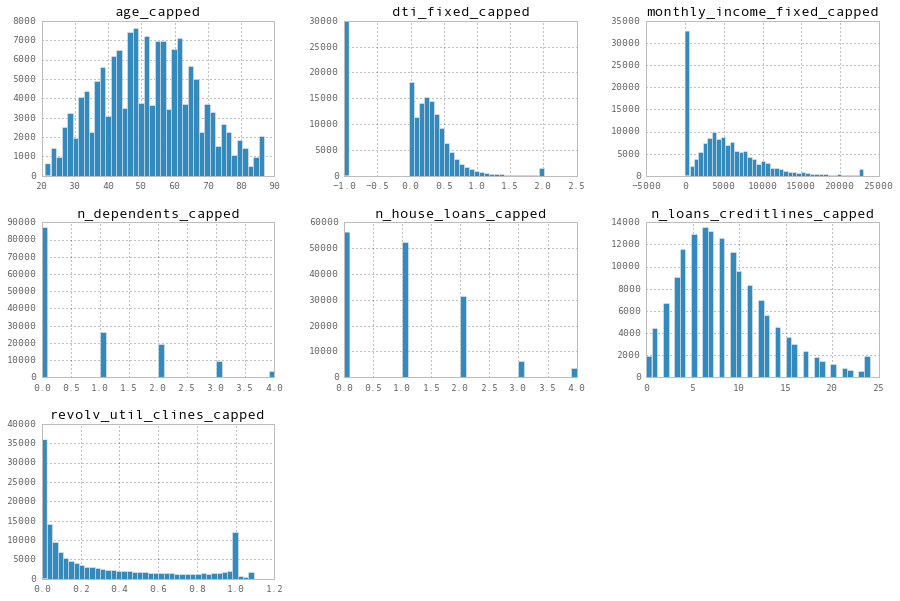

In [104]:
df_x_capped.hist( bins= 40, figsize=(15, 10))
plt.show()

In [105]:
df2.columns

Index([                         u'id',                   u'dlqin2yrs',
                               u'age',          u'revolv_util_clines',
                               u'dti',              u'monthly_income',
               u'n_loans_creditlines',               u'n_house_loans',
                      u'n_dependents',               u'n_30-59d_late',
                     u'n_60-89d_late',                  u'n_90d_late',
                              u'debt',                   u'debt_is_0',
                  u'mon_income_valid',             u'mon_income_is_1',
                   u'mon_income_is_0',        u'monthly_income_fixed',
                   u'mon_income_is_k',                u'n_creditline',
                        u'dti_is_int',                   u'dti_fixed',
                          u'dti_is_0',                   u'dti_gt_33',
                         u'dti_gt_40',                  u'age_capped',
         u'revolv_util_clines_capped',            u'dti_fixed_capped',
      

## Bivariate


### continous features

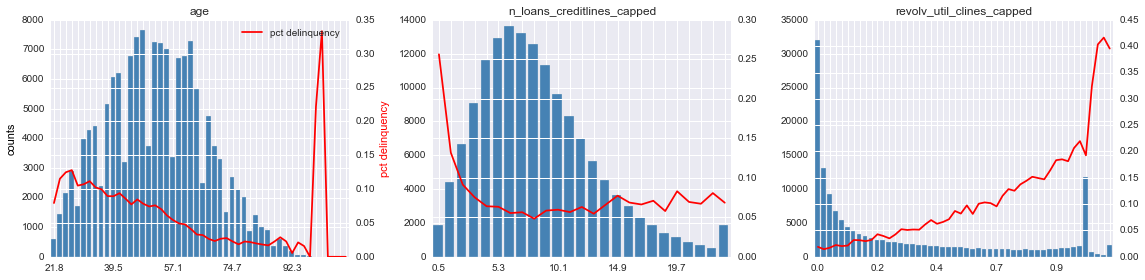

In [148]:
conti_col_names = [ u'age',  u'n_loans_creditlines_capped'
                   ,'revolv_util_clines_capped']
nbins = 50
#conti_col_names = ['age']
fig = plot_helper.plot_ybinary_xnumerical(df2[conti_col_names], df2[yname], n_per_row=3, nbins = nbins, figsize=(16,4))
fig.show()

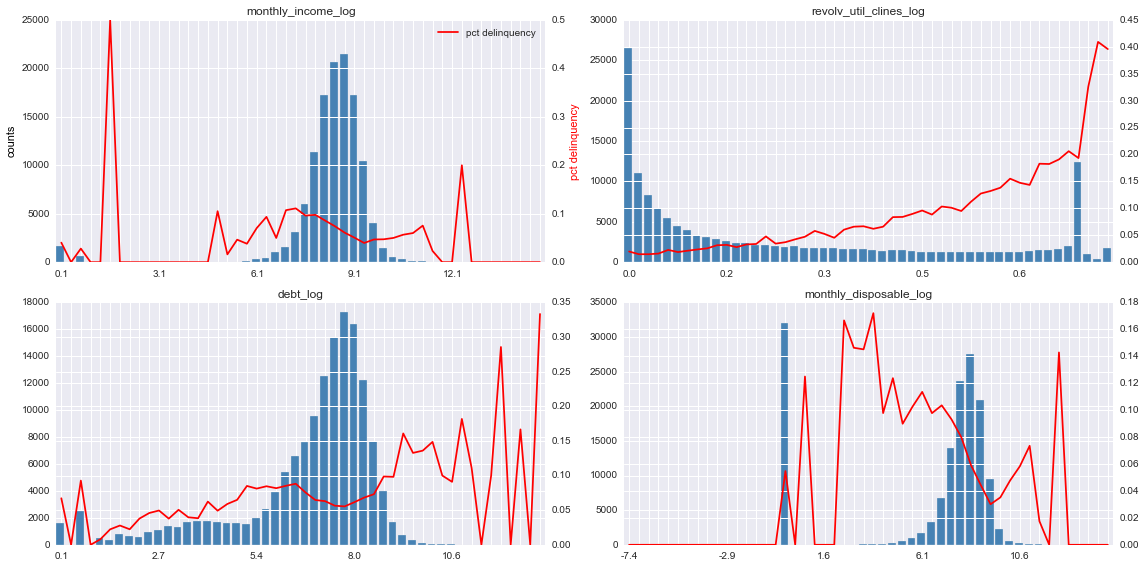

In [126]:
conti_col_names = ['monthly_income_log','revolv_util_clines_log', 'debt_log','monthly_disposable_log' ]
fig = plot_helper.plot_ybinary_xnumerical(df2[conti_col_names], df2[yname], n_per_row=2, nbins = 50, figsize=(16,8))
fig.show()

### categorical features

In [137]:
def plot_cat_var(df, catx_names, y_name, figsize=(16,4), n_per_row=3, title = ''):
    x_shift = 0
    nplots = len(catx_names)
    nrows_plot = nplots // n_per_row
    if nplots % n_per_row > 0:
        nrows_plot = nrows_plot + 1
    fig, axs = plt.subplots(nrows_plot, n_per_row, figsize=figsize)
    axs_flat = axs.flatten()
    for i, cat in enumerate(catx_names):
        ax = axs_flat[i]
        
        #avg_pos.plot(kind='line', color='r', ax=ax2, alpha = 0.5) # this does not align well
        #plt.plot(avg_pos.index.values+x_shift, avg_pos.values, color='r')
        cnt = df.groupby(cat)[y_name].sum()
        cnt.name = 'count'
        cnt.plot(kind='bar', color= 'steelblue', ax = ax, legend=True)#, position = 1) #darkgray
        ax2 = ax.twinx()
        avg_pos = df.groupby(cat)[y_name].mean()
        avg_pos.name = 'pct deliquency'
        avg_pos.plot(kind='bar', ax=ax2, color='r', alpha = 0.5, position = 0, legend=True)

        ax.set_title(cat)
        width = 0.4
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()
 

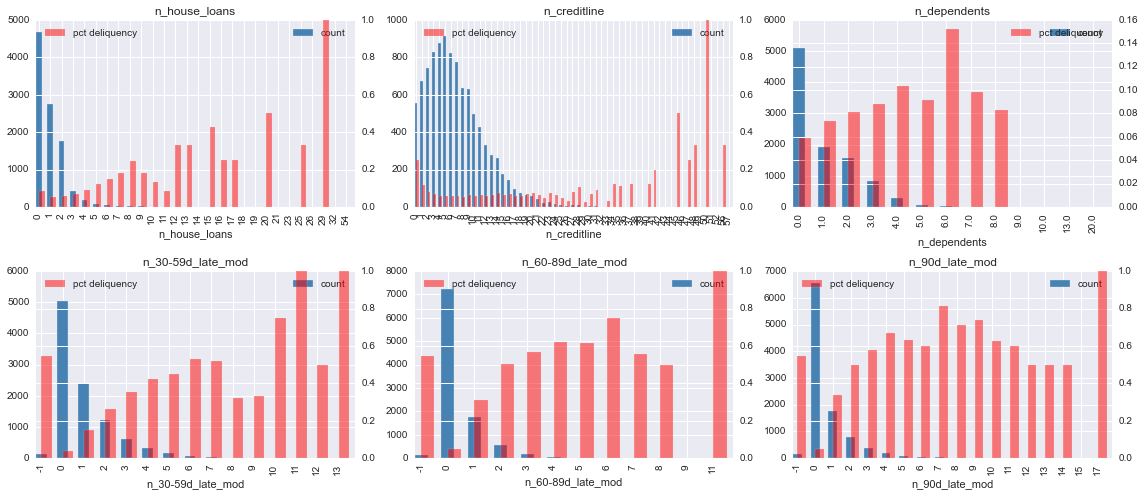

In [151]:
cat_col_names =  [
        u'n_house_loans', 'n_creditline',
   'n_dependents',
   u'n_30-59d_late_mod',
    u'n_60-89d_late_mod',
    'n_90d_late_mod',  ]
plot_cat_var(df2,cat_col_names,yname, figsize=(16,7))

## Interaction between continous variables

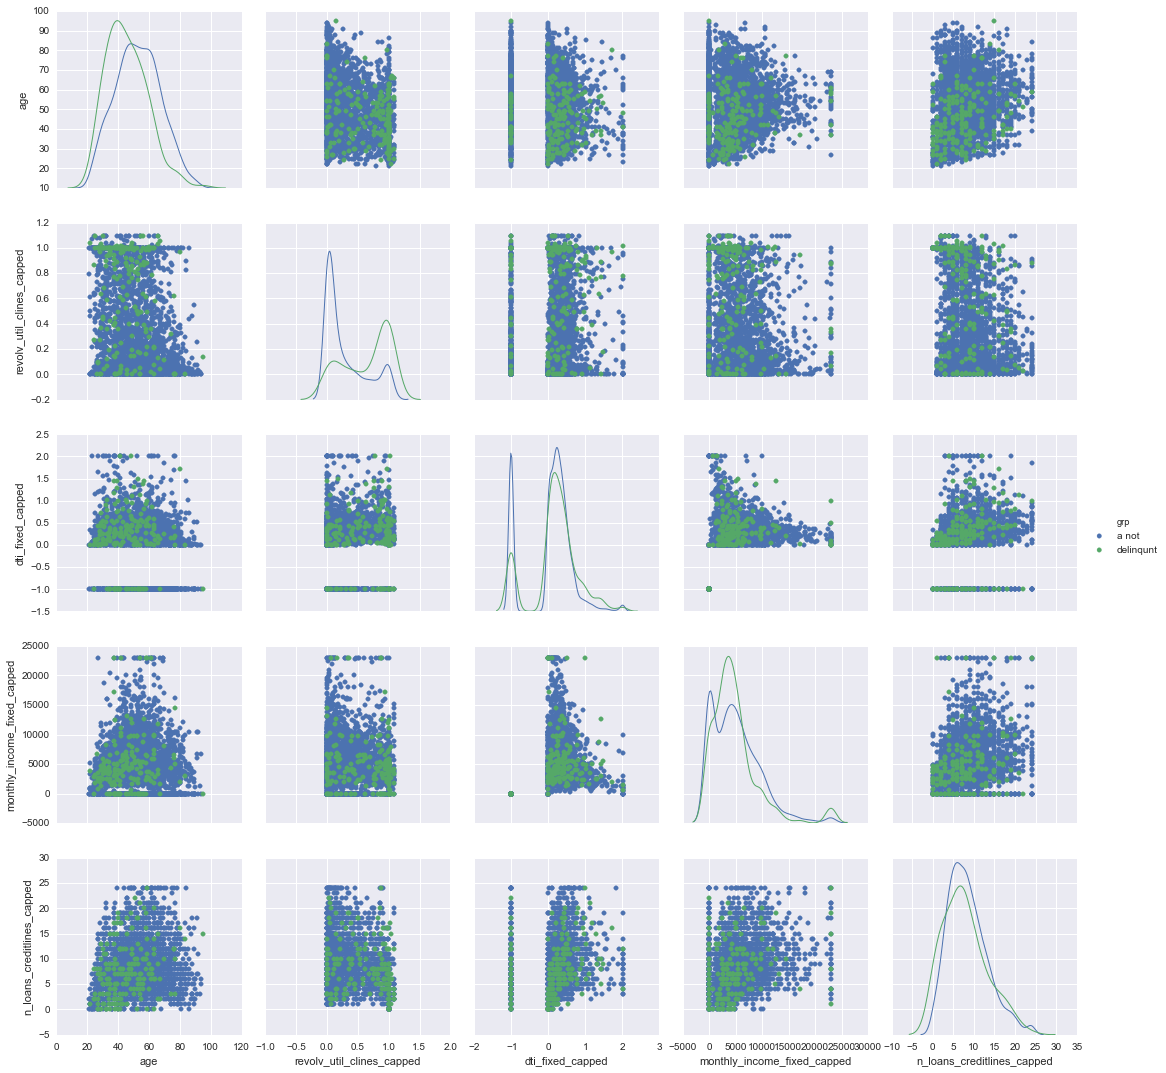

In [112]:
import seaborn as sns

sns.set()
n_samples = 3000
#colnames = [yname] + [t + '_capped'for t in conti_col_names]
# [ u'age', u'revolv_util_clines_capped', u'debt_income_ratio_capped'\
#    , u'monthly_income_capped', u'n_openloans_creditlines_capped']
df2['grp'] = df2[yname].apply(lambda x: 'delinqunt' if x == 1 else 'a not' )
#xnames_tmp = ['revolv_util_clines_capped', 'monthly_income_capped', 'grp']  
xnames_tmp = [ u'age', u'revolv_util_clines_capped', u'dti_fixed_capped'\
    , u'monthly_income_fixed_capped', u'n_loans_creditlines_capped', 'grp']
colnames= [yname] + xnames_tmp
rows_sampled = random.sample(df2.index, n_samples)
df_sample5k = df2.ix[rows_sampled, colnames]
sns.set()
g = sns.PairGrid(df_sample5k[xnames_tmp], diag_sharey=False, hue='grp')
#g = sns.PairGrid(df_sample5k[xnames_tmp], diag_sharey=False, hue=df_sample5k[yname])
g.map_diag(sns.kdeplot, lw=1)
g.map_lower(plt.scatter)
g.map_upper(plt.scatter)
g.add_legend()

In [ ]:
print df_x_capped.columns

In [ ]:
np.sum(df[yname])

In [ ]:
t = pd.cut(np.array([.2, 1.4, 2.5, 6.2, 9.7, 2.1]), 3)
print type(t)

In [ ]:
t, bins =   pd.cut(np.array([.2, 1.4, 2.5, 6.2, 9.7, 2.1]), 3, retbins=True)
print t
print bins

In [ ]:
df_test

In [ ]:
df_test_sub

In [ ]:
sys.path.append('credit')
from eda_uti import *

In [ ]:
k = 10000
lst_i = random.sample(xrange(df_orig.shape[0]), k)
df_s = df_orig.iloc[lst_i,:].copy(deep=True)

In [ ]:
df_tmp = feature_enginerring(df_orig)
df_tmp.describe().T

In [ ]:
df_s.columns

In [ ]:
df_s_2.total_late_days.count(), df_s_2.shape

In [111]:
df2.columns

Index([                         u'id',                   u'dlqin2yrs',
                               u'age',          u'revolv_util_clines',
                               u'dti',              u'monthly_income',
               u'n_loans_creditlines',               u'n_house_loans',
                      u'n_dependents',               u'n_30-59d_late',
                     u'n_60-89d_late',                  u'n_90d_late',
                              u'debt',                   u'debt_is_0',
                  u'mon_income_valid',             u'mon_income_is_1',
                   u'mon_income_is_0',        u'monthly_income_fixed',
                   u'mon_income_is_k',                u'n_creditline',
                        u'dti_is_int',                   u'dti_fixed',
                          u'dti_is_0',                   u'dti_gt_33',
                         u'dti_gt_40',                  u'age_capped',
         u'revolv_util_clines_capped',            u'dti_fixed_capped',
      

In [122]:
df2['debt'].min()

-1.0